


Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                    

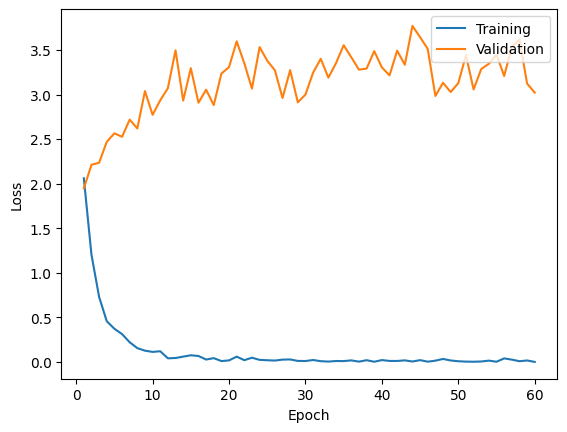

c:\Users\jeanp\OneDrive\Desktop\Thesis Environment\ipcv-env\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved as models/horses2.h5
4/4 [==============================] - 6s 1s/step


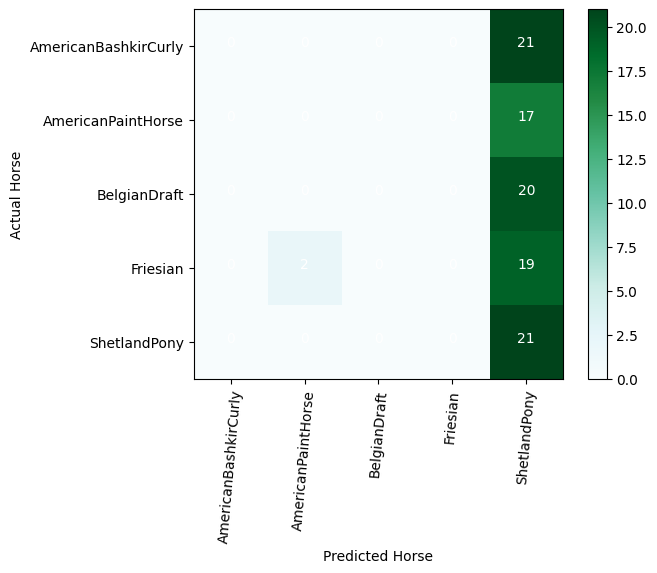

1/1 [==============================] - 0s 152ms/step
Prediction for ABC1.jpg: [[9.9979490e-01 2.2185910e-07 6.3324260e-05 1.4161394e-04 6.5842054e-10]] Class: AmericanBashkirCurly
Prediction for ABC2.jpg: [[9.9769825e-01 2.1763526e-04 3.0390561e-06 2.0808375e-03 2.3089038e-07]] Class: AmericanBashkirCurly
Prediction for ABC3.jpg: [[0.04756611 0.8397179  0.01537284 0.08465438 0.01268877]] Class: AmericanPaintHorse
Prediction for ABC4.jpg: [[9.9279755e-01 2.0839485e-08 1.2949463e-05 2.8154154e-06 7.1867723e-03]] Class: AmericanBashkirCurly
Prediction for AP1.jpg: [[3.2546632e-11 9.9999869e-01 3.9046686e-09 1.3045650e-06 5.0356720e-12]] Class: AmericanPaintHorse
Prediction for AP2.jpg: [[1.8968821e-10 9.9989104e-01 1.2102523e-06 1.0773142e-04 7.3367536e-12]] Class: AmericanPaintHorse
Prediction for AP3.jpg: [[1.1424809e-14 1.0000000e+00 3.2590425e-10 4.7120693e-11 2.7540528e-14]] Class: AmericanPaintHorse
Prediction for AP4.jpg: [[4.7354742e-11 9.9999940e-01 2.2752473e-09 5.9154559e-07 1.

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

# Load the ResNet-50 model
base_model = keras.applications.resnet.ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Print the summary of the base model
print(base_model.summary())

# Set your data folder and parameters
data_folder = 'data - Copy/horse_photos'
pretrained_size = (224, 224)
batch_size = 100

datagen = image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.3,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = datagen.flow_from_directory(
    data_folder,
    target_size=pretrained_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    data_folder,
    target_size=pretrained_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

classnames = list(train_generator.class_indices.keys())
print("Class names:", classnames)

for layer in base_model.layers[-20:]:
    layer.trainable = True

x = base_model.output
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Flatten()(x)
prediction_layer = keras.layers.Dense(len(classnames), activation='softmax')(x)
model = keras.models.Model(inputs=base_model.input, outputs=prediction_layer)

learning_rate = 0.0001
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

# Print the summary of the entire model
print(model.summary())

# Train the model
num_epochs = 60
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=num_epochs
)

# Plot training and validation loss
epoch_nums = range(1, num_epochs + 1)
training_loss = history.history["loss"]
validation_loss = history.history["val_loss"]
plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

# Save the trained model
modelFileName = 'models/horses2.h5'
model.save(modelFileName)
del model
print('Model saved as', modelFileName)

# Load the saved model for inference
model = keras.models.load_model('models/horses2.h5')

# Generate predictions from validation data
x_test = validation_generator[0][0]
y_test = validation_generator[0][1]
class_probabilities = model.predict(x_test)
predictions = np.argmax(class_probabilities, axis=1)
true_labels = np.argmax(y_test, axis=1)

# Plot the confusion matrix with values
cm = confusion_matrix(true_labels, predictions)
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.BuGn)

# Add values to each cell
for i in range(len(classnames)):
    for j in range(len(classnames)):
        plt.text(j, i, str(cm[i, j]), horizontalalignment="center", color="white")

plt.colorbar()
tick_marks = np.arange(len(classnames))
plt.xticks(tick_marks, classnames, rotation=85)
plt.yticks(tick_marks, classnames)
plt.xlabel("Predicted Horse")
plt.ylabel("Actual Horse")
plt.show()

# Inference on new images
image_folder = './inferencing - Copy'
image_files = os.listdir(image_folder)

img_width, img_height = 224, 224

preprocessed_images = []
for img_file in image_files:
    img_path = os.path.join(image_folder, img_file)
    img = image.load_img(img_path, target_size=(img_width, img_height))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_preprocessed = preprocess_input(img_array)
    preprocessed_images.append(img_preprocessed)

predictions = [model.predict(img) for img in preprocessed_images]

# Display predictions
for i, img_file in enumerate(image_files):
    index = int(np.argmax(predictions[i], axis=1)[0])
    print(f"Prediction for {img_file}: {predictions[i]} Class: {classnames[index]}")


1/1 [==============================] - 0s 159ms/step


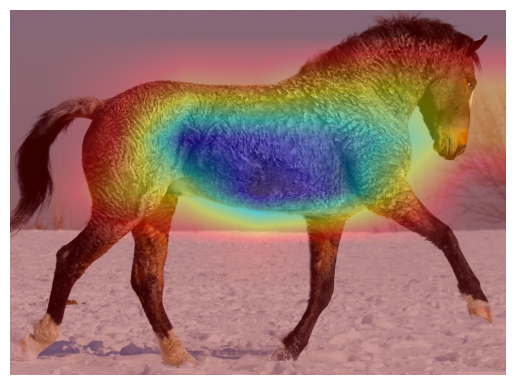

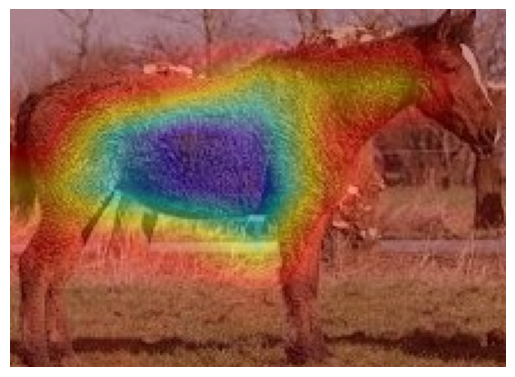

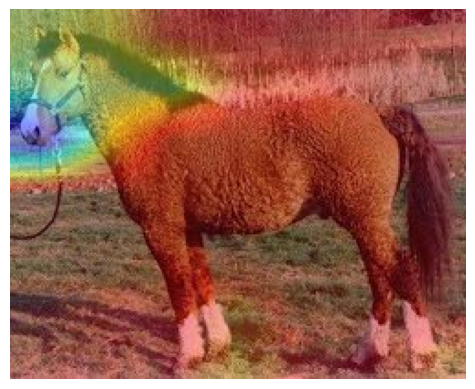

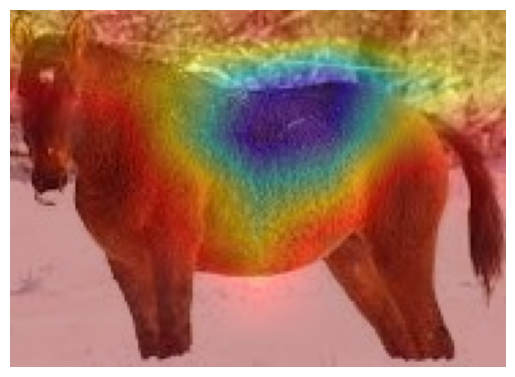

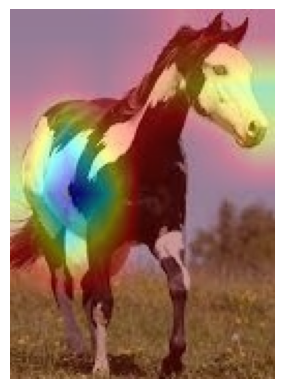

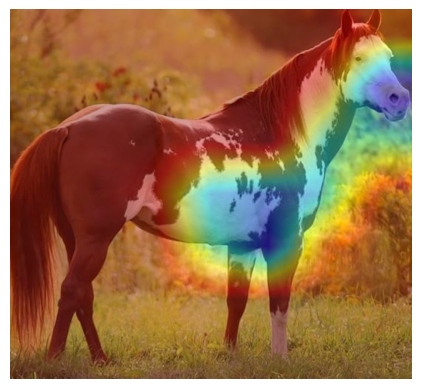

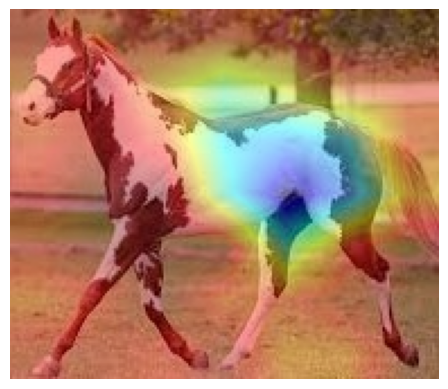

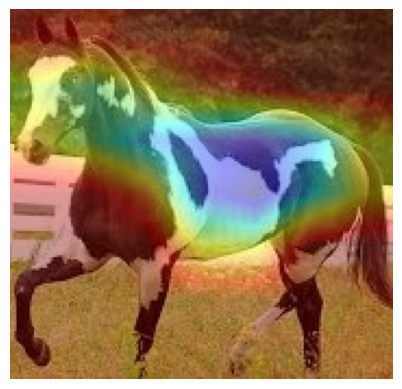

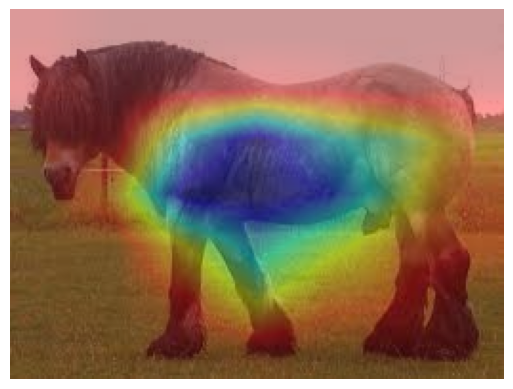

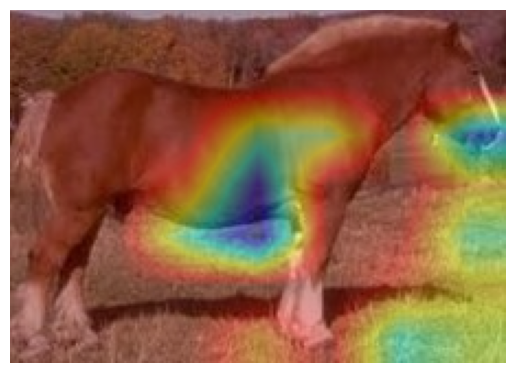

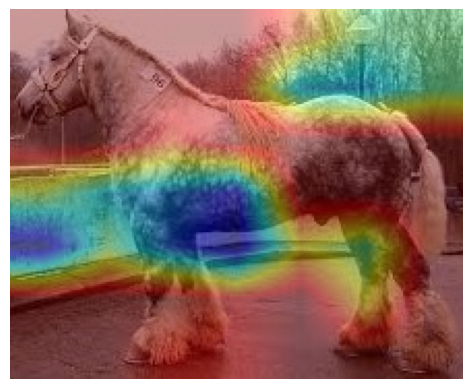

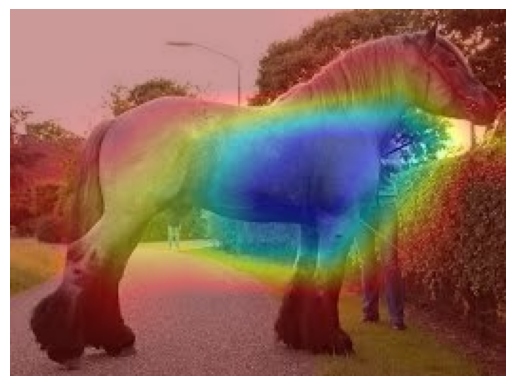

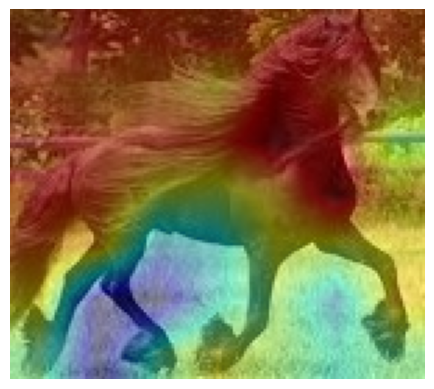

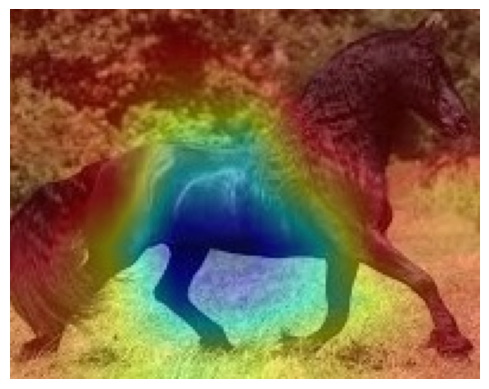

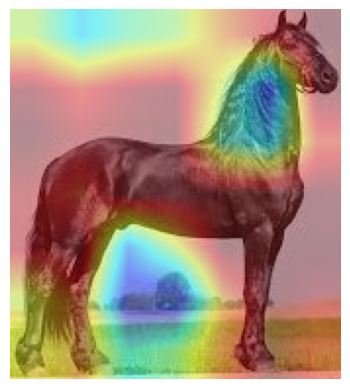

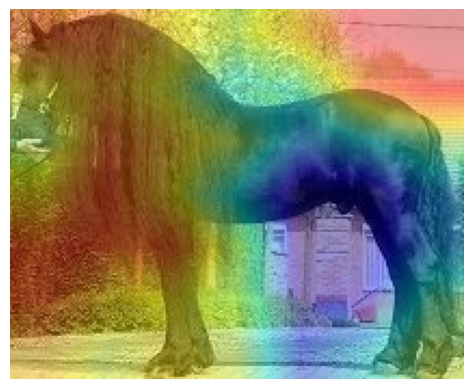

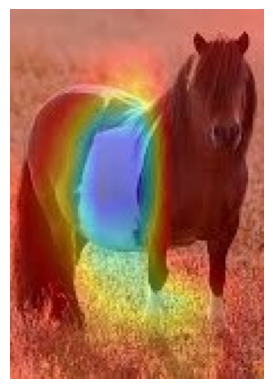

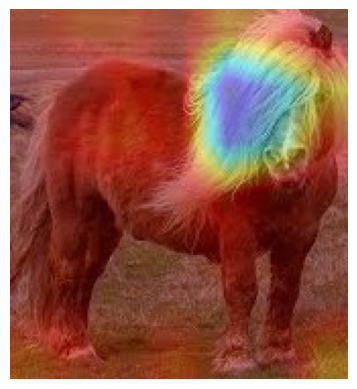

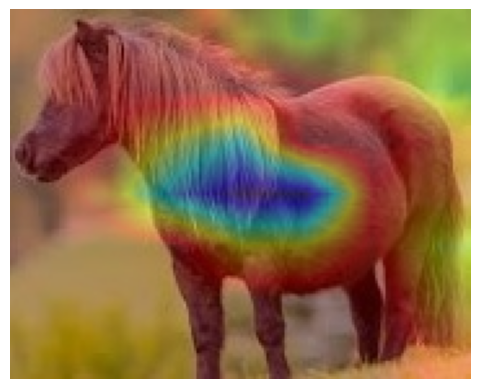

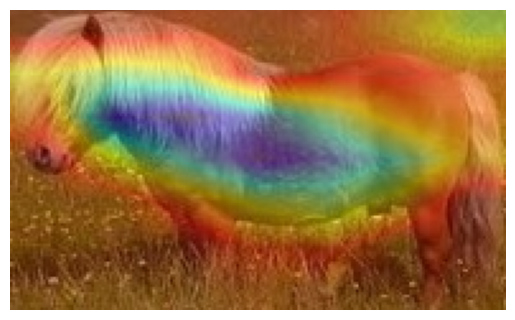

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
import tensorflow as tf

def get_last_conv_layer_name(model):
    # Find the last convolutional layer
    for layer in reversed(model.layers):
        if 'conv' in layer.name:
            return layer.name
    raise ValueError("No convolutional layer found in the model.")

def get_heatmap(model, img_array, last_conv_layer_name):
    grad_model = Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        class_idx = tf.argmax(preds[0])
        class_output = preds[:, class_idx]

    grads = tape.gradient(class_output, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer_output), axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    return heatmap.astype(np.float32)

def plot_heatmap(img_path, heatmap):
    img = cv2.imread(img_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Convert BGR to RGB
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Apply heatmap as an overlay
    superimposed_img = cv2.addWeighted(img_rgb, 0.6, heatmap, 0.4, 0)

    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.show()

# Inference on new images
image_folder = './inferencing - Copy'
image_files = os.listdir(image_folder)

preprocessed_images = []
for img_file in image_files:
    img_path = os.path.join(image_folder, img_file)
    img = image.load_img(img_path, target_size=(img_width, img_height))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_preprocessed = preprocess_input(img_array)
    preprocessed_images.append(img_preprocessed)

predictions = [model.predict(img) for img in preprocessed_images]

# Display predictions with heatmap
for i, img_file in enumerate(image_files):
    img_path = os.path.join(image_folder, img_file)
    last_conv_layer_name = get_last_conv_layer_name(model)
    heatmap = get_heatmap(model, preprocessed_images[i], last_conv_layer_name)
    plot_heatmap(img_path, heatmap)